Abel Tadesse <br />
Jason Yi <br />
Richy Chen <br />

In [12]:

import pandas as pd
%matplotlib inline
import os
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.metrics import top_k_categorical_accuracy
def top_3_accuracy(x,y): return top_k_categorical_accuracy(x,y, 3)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from glob import glob
import gc
gc.enable()
import numpy as np
import tensorflow as tf
import random
from ast import literal_eval
from sklearn.utils import shuffle
training_set = '../train_simplified/'
from os import listdir
from os.path import isfile, join

ALL_TRAIN_PATHS = [join(training_set, f) for f in listdir(training_set) if isfile(join(training_set, f))]

In [13]:
tf.test.is_gpu_available()

True

# Clean and Preprocess

In [14]:
from ast import literal_eval
COL_NAMES = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

def _stack_it(raw_strokes):
    """preprocess the string and make 
    a standard Nx3 stroke vector"""
    stroke_vec = literal_eval(raw_strokes) # string->list
    # unwrap the list
    in_strokes = [(xi,yi,i)  
     for i,(x,y) in enumerate(stroke_vec) 
     for xi,yi in zip(x,y)]
    c_strokes = np.stack(in_strokes)
    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] = [1]+np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    # pad the strokes with zeros
    return pad_sequences(c_strokes.swapaxes(0, 1), 
                         maxlen=STROKE_COUNT, 
                         padding='post').swapaxes(0, 1)
def read_batch(samples=5, 
               start_row=0,
               max_rows = 1000):
    """
    load and process the csv files
    this function is horribly inefficient but simple
    """
    out_df_list = []
    for c_path in ALL_TRAIN_PATHS:
        c_df = pd.read_csv(c_path, nrows=max_rows, skiprows=start_row)
        c_df.columns=COL_NAMES
        out_df_list += [c_df.sample(samples)[['drawing', 'word']]]
    full_df = pd.concat(out_df_list)
    full_df['drawing'] = full_df['drawing'].\
        map(_stack_it)
    
    return full_df

In [15]:
batch_size = 4096
STROKE_COUNT = 196
TRAIN_SAMPLES = 750
VALID_SAMPLES = 75
TEST_SAMPLES = 500

In [16]:
train_args = dict(samples=TRAIN_SAMPLES, 
                  start_row=0, 
                  max_rows=int(TRAIN_SAMPLES*1.5))
valid_args = dict(samples=VALID_SAMPLES, 
                  start_row=train_args['max_rows']+1, 
                  max_rows=VALID_SAMPLES+25)
test_args = dict(samples=TEST_SAMPLES, 
                 start_row=valid_args['max_rows']+train_args['max_rows']+1, 
                 max_rows=TEST_SAMPLES+25)
train_df = read_batch(**train_args)
valid_df = read_batch(**valid_args)
test_df = read_batch(**test_args)
word_encoder = LabelEncoder()
word_encoder.fit(train_df['word'])
print('words', len(word_encoder.classes_), '=>', ', '.join([x for x in word_encoder.classes_]))

words 340 => The Eiffel Tower, The Great Wall of China, The Mona Lisa, airplane, alarm clock, ambulance, angel, animal migration, ant, anvil, apple, arm, asparagus, axe, backpack, banana, bandage, barn, baseball, baseball bat, basket, basketball, bat, bathtub, beach, bear, beard, bed, bee, belt, bench, bicycle, binoculars, bird, birthday cake, blackberry, blueberry, book, boomerang, bottlecap, bowtie, bracelet, brain, bread, bridge, broccoli, broom, bucket, bulldozer, bus, bush, butterfly, cactus, cake, calculator, calendar, camel, camera, camouflage, campfire, candle, cannon, canoe, car, carrot, castle, cat, ceiling fan, cell phone, cello, chair, chandelier, church, circle, clarinet, clock, cloud, coffee cup, compass, computer, cookie, cooler, couch, cow, crab, crayon, crocodile, crown, cruise ship, cup, diamond, dishwasher, diving board, dog, dolphin, donut, door, dragon, dresser, drill, drums, duck, dumbbell, ear, elbow, elephant, envelope, eraser, eye, eyeglasses, face, fan, feathe

# Stroke-based Classification

In [17]:
def get_Xy(in_df):
    X = np.stack(in_df['drawing'], 0)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y
train_X, train_y = get_Xy(train_df)
valid_X, valid_y = get_Xy(valid_df)
test_X, test_y = get_Xy(test_df)
print(train_X.shape)

(255000, 196, 3)


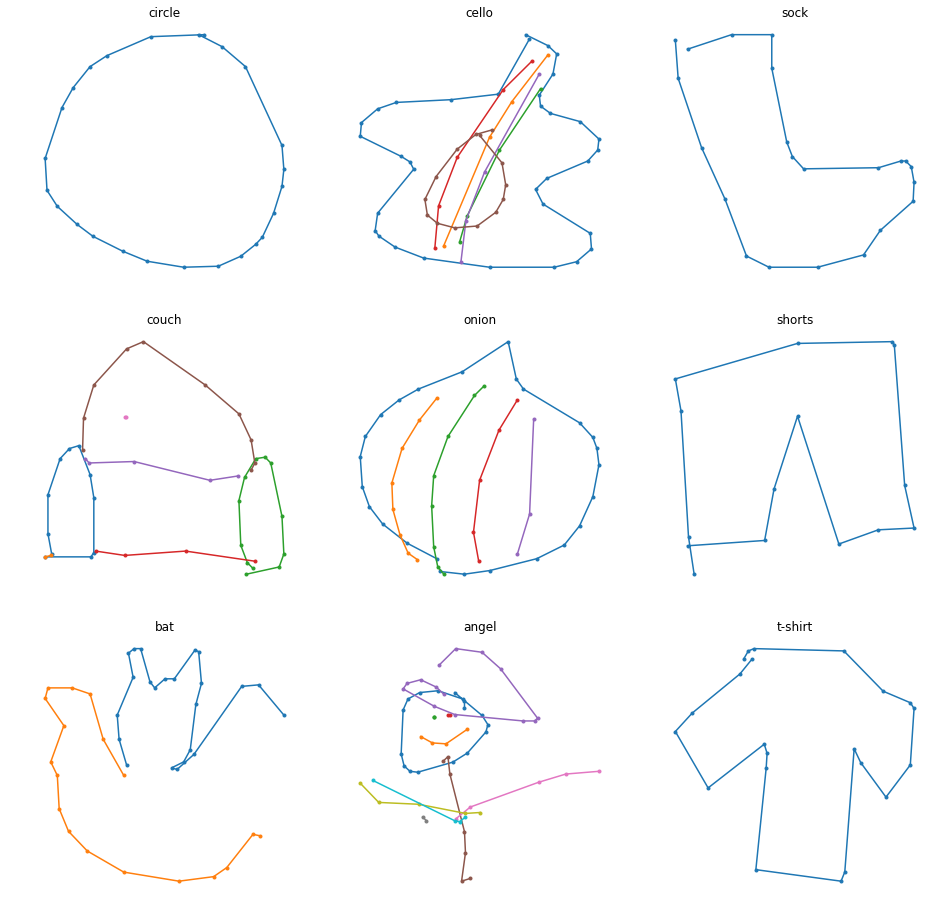

In [18]:
fig, m_axs = plt.subplots(3,3, figsize = (16, 16))
rand_idxs = np.random.choice(range(train_X.shape[0]), size = 9)
for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = train_X[c_id]
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1)
    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0], 
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(word_encoder.classes_[np.argmax(train_y[c_id])])

## RNN Model

In [20]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, LSTM, Dense, Dropout
from keras.layers import CuDNNLSTM as LSTM 
stroke_read_model = Sequential()
stroke_read_model.add(BatchNormalization(input_shape = (None,)+train_X.shape[2:]))

stroke_read_model.add(Conv1D(48, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(64, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(96, (3,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = True))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = False))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(512))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(len(word_encoder.classes_), activation = 'softmax'))
stroke_read_model.compile(optimizer = 'adam', 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy', top_3_accuracy])
stroke_read_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, None, 3)           12        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 48)          768       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 48)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          15424     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 96)          18528     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 96)          0         
__________

In [21]:
weight_path="{}_weights.best.hdf5".format('stroke_lstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, 
                                   verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]


/home/abelleulseged/miniconda3/envs/cs152/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [22]:
from IPython.display import clear_output
stroke_read_model.fit(train_X, train_y,
                      validation_data = (valid_X, valid_y), 
                      batch_size = batch_size,
                      epochs = 50,
                      callbacks = callbacks_list)
clear_output()


In [23]:
stroke_read_model.load_weights(weight_path)
lstm_results = stroke_read_model.evaluate(test_X, test_y, batch_size = 4096)
print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results[1], 100*lstm_results[2]))

170000/170000 [==============================] - 18s 104us/step
Accuracy: 43.6%, Top 3 Accuracy 65.5%


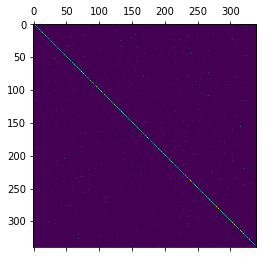

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
test_cat = np.argmax(test_y, 1)
pred_y = stroke_read_model.predict(test_X, batch_size = 4096)
pred_cat = np.argmax(pred_y, 1)
plt.matshow(confusion_matrix(test_cat, pred_cat))